In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

import copy

In [2]:
import configuration
config = configuration.Config()

In [3]:
from utils_model_sampling import sample_models_across_time
from utils import load_models

## Note: running on unigram scores that may not be fully correct -- will correct when OM is back up.

In [4]:
levdist_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('levdist'))
# Remove 0.5 and 4.0 because they are sparse.
levdist_scores_across_time = levdist_scores_across_time[~levdist_scores_across_time.age.isin({0.5, 4.0})]
levdist_scores_across_time['likelihood_type'] = 'Levenshtein Distance'

In [5]:
wfst_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order('wfst'))
# Remove 0.5 and 4.0 because they are sparse.
wfst_scores_across_time = wfst_scores_across_time[~wfst_scores_across_time.age.isin({0.5, 4.0})]
wfst_scores_across_time['likelihood_type'] = 'WFST'

In [6]:
raw_scores_across_time = pd.concat([levdist_scores_across_time, wfst_scores_across_time])

In [7]:
# Possibly too complex to generate the betas in the title automatically
# -- for now, just display the betas in the notebook separately.

from utils_model_sampling import hyperparameter_utils
from pprint import pprint

all_args = load_models.gen_all_model_args()

beta_set = {}
lambda_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'beta')
    beta_set[model_title] = round(this_beta, 3)
    this_lambda = hyperparameter_utils.get_optimal_hyperparameter_value(*arg_set, 'lambda')
    lambda_set[model_title] = round(this_lambda, 3)

    
pprint(beta_set)
pprint(lambda_set)

{'Adult BERT without tags, , +-20 utts context': 3.4,
 'Adult BERT without tags, , same utt only': 4.0,
 'CHILDES BERT with tags, , +-20 utts context': 3.0,
 'CHILDES BERT with tags, , same utt only': 3.1,
 'CHILDES BERT with tags, older children, +-20 utts context': 3.2,
 'CHILDES BERT with tags, older children, same utt only': 3.3,
 'CHILDES BERT with tags, younger children, +-20 utts context': 2.9,
 'CHILDES BERT with tags, younger children, same utt only': 2.9,
 'CHILDES BERT without tags, , +-20 utts context': 3.1,
 'CHILDES BERT without tags, , same utt only': 3.2,
 'CHILDES BERT without tags, older children, +-20 utts context': 3.3,
 'CHILDES BERT without tags, older children, same utt only': 3.4,
 'CHILDES BERT without tags, younger children, +-20 utts context': 3.0,
 'CHILDES BERT without tags, younger children, same utt only': 3.0,
 'CHILDES unigram without tags, , same utt only': 3.4,
 'Flat prior without tags, , same utt only': 3.7}
{'Adult BERT without tags, , +-20 utts co

In [8]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram', 
}


tags_context_only = {
    "CHILDES BERT with tags, , +-20 utts context",
    'CHILDES BERT with tags, older children, +-20 utts context',
    'CHILDES BERT with tags, younger children, +-20 utts context',
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, older children, +-20 utts context',
    'CHILDES BERT without tags, younger children, +-20 utts context',
    'Flat Unigram',
}

merge_orig_tags = copy.deepcopy(tags_context_only)
merge_orig_tags.update(original_set_of_models)

scores_across_time = raw_scores_across_time.copy()


In [9]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_probability','posterior_entropy','prior_probability',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance','likelihood_type']]
%R -i scores_across_time_short

In [10]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')


In [11]:
set(scores_across_time['model']) #.columns # Flat is not available. You can add the flat score via? a manual run.
# But it will mix?

{'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , +-20 utts context',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

In [12]:
%%R 
get_ref_df = function(model, single_df){
    rdf = single_df
    single_df$line_model = single_df$model
    single_df$model = model
    return(single_df) 
}

# 10 Average Prior Surprisal

In [13]:
%%R
names(successes_across_time)

aggregate(prior_probability ~ model, successes_across_time, function(x){mean(-1 * log(x, base = 2))})

                      model prior_probability
1          CDL+Context+Tags          3.334909
2               CDL+Context          3.400071
3           CDL+OneUtt+Tags          5.070019
4                CDL+OneUtt          5.266370
5              BERT+Context          4.625720
6               BERT+OneUtt          7.340327
7    CDL+Older+Context+Tags          3.312404
8         CDL+Older+Context          3.410596
9          CDL+Older+OneUtt          5.247724
10    CDL+Older+OneUtt+Tags          5.069155
11 CDL+Younger+Context+Tags          3.526589
12      CDL+Younger+Context          3.565772
13  CDL+Younger+OneUtt+Tags          5.380233
14       CDL+Younger+OneUtt          5.476085
15            CHILDES 1gram          8.781867
16             UniformPrior         12.948367


In [14]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_probability',
'bert_token_id','likelihood_type')], model, prior_probability)
successes_across_time_wide = subset(successes_across_time_wide, likelihood_type == 'WFST')
head(successes_across_time_wide)

   bert_token_id likelihood_type CDL+Context+Tags  CDL+Context CDL+OneUtt+Tags
2          10577            WFST     7.979647e-07 8.214258e-07    6.120954e-05
4          39428            WFST     5.150315e-04 5.371947e-04    2.307286e-03
6          39594            WFST     6.768355e-01 4.593022e-01    2.307286e-03
8          41265            WFST     5.280750e-01 7.641144e-01    2.072786e-01
10         41266            WFST     3.326443e-01 2.302753e-01    7.433255e-03
12         41756            WFST     5.163042e-05 3.995757e-06    1.045088e-03
     CDL+OneUtt BERT+Context  BERT+OneUtt CDL+Older+Context+Tags
2  0.0001455111 3.668524e-06 6.657388e-05           9.982572e-06
4  0.0020883488 2.486866e-04 1.489496e-04           1.056483e-03
6  0.0020883488 1.485306e-02 1.489496e-04           8.001575e-01
8  0.0415592827 7.342635e-01 2.195508e-02           7.279799e-01
10 0.0043988395 3.378104e-01 3.086058e-04           1.881394e-01
12 0.0003057218 6.034848e-06 3.062862e-06           6.055

In [15]:
%%R
dim(successes_across_time_wide)

[1] 43998    18


In [16]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

R[write to console]: Error in x - y : non-numeric argument to binary operator




Error in x - y : non-numeric argument to binary operator


# Split plots (two subsets)

In [17]:
%%R

filter_model_subset = function(this_df, model_names_list){
    #return(this_df[this_df$model %in% model_names_list])
    return(subset(this_df, this_df$model %in% model_names_list))
}


In [18]:
%%R
overview_set <- c(
    "CDL+Context",
    "CDL+OneUtt",
    "Bert+Context",
    "Bert+OneUtt",
    "CHILDES 1gram",
    "UniformPrior"
)

splits_tags_set <-  c(
    "CDL+Context+Tags",
    "CDL+Context",
    "CDL+Older+Context+Tags",
    "CDL+Older+Context",
    "CDL+Younger+Context+Tags",
    "CDL+Younger+Context"
)

### Posterior Surprisal Across Ages

In [19]:

%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_probability ~ age + model + likelihood_type, successes_across_time ,\
                function(x){mean(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age) = c('age','model','likelihood','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_probability ~ age + model + likelihood_type, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','likelihood','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)


    age                    model           likelihood posterior_surprisal_mean
1   1.5             BERT+Context Levenshtein Distance                2.7385054
2   1.5             BERT+Context                 WFST                1.8621092
3   1.5              BERT+OneUtt Levenshtein Distance                4.8254677
4   1.5              BERT+OneUtt                 WFST                3.5112240
5   1.5              CDL+Context Levenshtein Distance                1.7204210
6   1.5         CDL+Context+Tags Levenshtein Distance                1.7091283
7   1.5         CDL+Context+Tags                 WFST                1.0595321
8   1.5              CDL+Context                 WFST                1.0683329
9   1.5        CDL+Older+Context Levenshtein Distance                1.8135313
10  1.5   CDL+Older+Context+Tags Levenshtein Distance                1.7692095
11  1.5   CDL+Older+Context+Tags                 WFST                1.0870793
12  1.5        CDL+Older+Context                 WFS

38               0.08683576
39               0.06753382
40               0.07079497
41               0.09602710
42               0.09405973
43               0.07180620
44               0.07194256
45               0.12682855
46               0.12427189
47               0.09878227
48               0.10041502
49               0.12197481
50               0.11987372
51               0.09384363
52               0.10002782
53               0.08945089
54               0.08789583
55               0.06801636
56               0.06752032
57               0.12058526
58               0.12086058
59               0.09783529
60               0.09683749
61               0.13324747
62               0.10533443
63               0.12662932
64               0.11735271
65               0.02772197
66               0.02095230
67               0.03723394
68               0.02836019
69               0.02280490
70               0.02246320
71               0.01658675
72               0.01682626
73               0.0

,age,model,likelihood,posterior_surprisal_mean,posterior_surprisal_sem
1,1.5,BERT+Context,Levenshtein Distance,2.738505,0.061731
2,1.5,BERT+Context,WFST,1.862109,0.048144
3,1.5,BERT+OneUtt,Levenshtein Distance,4.825468,0.081883
4,1.5,BERT+OneUtt,WFST,3.511224,0.065088
5,1.5,CDL+Context,Levenshtein Distance,1.720421,0.047906
...,...,...,...,...,...
188,3.0,CDL+Younger+OneUtt,WFST,0.935017,0.022869
189,3.0,CHILDES 1gram,Levenshtein Distance,3.174350,0.042496
190,3.0,CHILDES 1gram,WFST,1.918573,0.030233
191,3.0,UniformPrior,Levenshtein Distance,4.573752,0.044331


## Subset plots

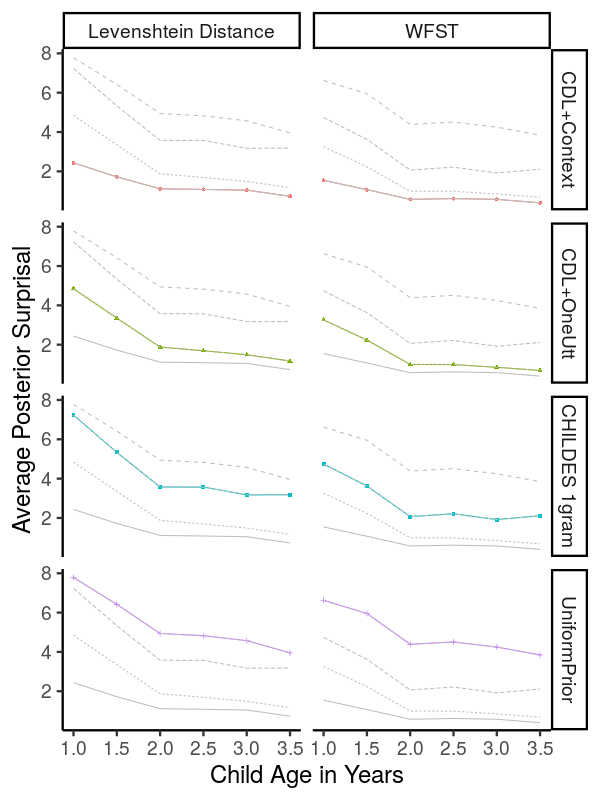

In [20]:
%%R -w 600 -h 800

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_grid(model~likelihood) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


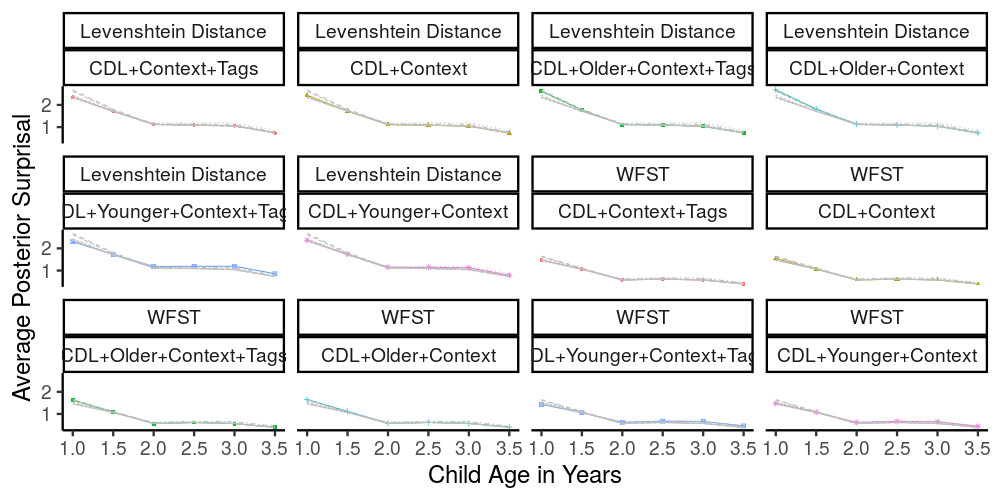

In [21]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
    ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(likelihood~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=posterior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


# Prior surprisal

In [ ]:

%R mean_surprisal_by_age = aggregate(prior_probability ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_probability ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base = 2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 


### Prior Surprisal Across Ages

In [ ]:
%%R -w 1000 -h 500

overview_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, overview_set)
    
overview_mean_surprisal_for_gray = do.call('rbind', lapply(unique(overview_mean_surprisal_by_age$model), function(model){ get_ref_df(model, overview_mean_surprisal_by_age)}))

ggplot(overview_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=overview_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')

# # Best performing CDL Context all/all, CHILDES 1gram and Uniform Prior 


In [ ]:
%%R -w 1000 -h 500

subset_mean_surprisal_by_age <- filter_model_subset(mean_surprisal_by_age, splits_tags_set)
    
subset_mean_surprisal_for_gray = do.call('rbind', lapply(unique(subset_mean_surprisal_by_age$model), function(model){ get_ref_df(model, subset_mean_surprisal_by_age)}))

ggplot(subset_mean_surprisal_by_age) + geom_point(aes(x=age, y=prior_surprisal_mean, color=model,
    shape = model)) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
    ) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
    ymax=prior_surprisal_mean + .5*prior_surprisal_sem, color=model ), width=0) + theme_classic(
    base_size = 24) + ylab('Average Prior Surprisal') + xlab('Child Age in Years') +
    facet_wrap(~model) + geom_line(data=subset_mean_surprisal_for_gray, aes(x=age,y=prior_surprisal_mean, linetype = line_model),colour='gray', alpha=1) +
    theme(legend.position='none')


In [ ]:
scores_across_time_short.set.value_counts()

### Posterior Entropy Stratified by Successes vs. Failures

In [ ]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

In [ ]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [ ]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [ ]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

In [ ]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

In [ ]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [ ]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

In [ ]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

In [ ]:
# the problem here is that edit_distance needs to be useful to stratify 
# the posteriors from the models that use WFSTs

In [22]:
%%R
levdists = subset(successes_across_time, likelihood_type = "Levenshtein Distance")
dim(levdists)

[1] 1407936      12


In [23]:
%%R
wfsts = subset(successes_across_time, likelihood_type == "WFST")
dim(wfsts)

[1] 703968     12


In [ ]:
# !!! why are there so many fewer wfst than levdist entries

In [24]:
%%R
levdists$wfst_distance = 0
wfsts$wfst_distance = wfsts$edit_distance
wfsts$edit_distance = NULL

In [25]:
%%R
wfsts = merge(wfsts, levdists[,c('bert_token_id','edit_distance')], by='bert_token_id')

KeyboardInterrupt: 

In [ ]:
# something ate all of the RAM

In [ ]:
%%R
ed = rbind(wfsts, levdists)

In [ ]:
%%R
unique(ed$edit_distance )

In [ ]:
%%R
surprisal_by_edit_distance = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, 
    subset(successes_across_time), 
    function(x){mean(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'likelihood_type', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_probability ~ edit_distance + model + likelihood_type, successes_across_time, 
    function(x){sem(-1 * log(x, base = 2))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','likelihood_type','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)


In [ ]:
%%R
surprisal_by_edit_distance[1,]

In [ ]:
%%R

surprisal_by_edit_distance_for_plot = subset(surprisal_by_edit_distance, edit_distance <= 6)

surprisal_for_gray = do.call('rbind', lapply(unique(surprisal_by_edit_distance_for_plot$model), function(model){ get_ref_df(model, surprisal_by_edit_distance_for_plot)}))

p1= ggplot(surprisal_by_edit_distance_for_plot) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model, linetype=likelihood_type)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic") +
facet_wrap(~model) + geom_line(data=surprisal_for_gray, aes(x=edit_distance,y=mean_posterior_surprisal, linetype = line_model),colour='gray', alpha=1)+
theme(legend.position='none')

ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [ ]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


In [ ]:
%%R

# Added: no subsetting for the odds uniform prior

p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_all.pdf', height=6, width=8)    
print(p2)

In [ ]:
%%R

subset_surprisal_by_edit_distance <- filter_model_subset(surprisal_by_edit_distance, splits_tags_set)

p2= ggplot(subset(subset_surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_subset.pdf', height=6, width=8)    
print(p2)

In [ ]:
%%R

overview_surprisal_by_edit_distance <- filter_model_subset(surprisal_by_edit_distance, overview_set)

p2= ggplot(subset(overview_surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale_overview.pdf', height=6, width=8)    
print(p2)

In [ ]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [ ]:
%%R
library(plotROC)

In [ ]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

In [ ]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

In [ ]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


In [ ]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 3),')')

In [ ]:
%%R
scores_across_time_short$model_with_auc[1:10]

In [ ]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=12, width=12)    